# Baseline Model Rigor

**Goal**: Elevate the validation of our baseline models to a production-grade standard using Rolling Origin Cross-Validation (ROCV) and segmented error analysis.

**Models Under Audit**:
*   `SeasonalNaive`: The simple benchmark.
*   `MovingAverage`: The robust curve smoother.
*   `PiecewiseHybrid`: ADI/CV2 classification.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from tqdm.notebook import tqdm

# Add src to path
sys.path.append('..')

from src.baselines.models import SeasonalNaive, MovingAverage
from src.baselines.optimized import PiecewiseHybrid

## 1. Load Data

In [2]:
# Load canonical weekly data
df = pd.read_parquet('../data/processed/weekly_canon.parquet')
print(f"Data loaded: {df.shape}")
print(f"Date Range: {df['week_start'].min()} to {df['week_start'].max()}")

# Ensure sorted
df = df.sort_values(['store_nbr', 'family', 'week_start']).reset_index(drop=True)

Data loaded: (434808, 19)
Date Range: 2012-12-31 00:00:00 to 2017-08-28 00:00:00


## 2. Rolling Origin Cross-Validation (ROCV)

We will simulate a production environment by retraining (or recalibrating) and forecasting over multiple cutoff points.

**Config**:
*   `horizon`: 8 weeks
*   `stride`: 4 weeks
*   `n_splits`: 5 folds

In [3]:
def rolling_origin_backtest(df, model_cls, model_params={}, horizon=8, stride=4, n_splits=5):
    # Determine cutoffs
    all_weeks = sorted(df['week_start'].unique())
    train_end_indices = []
    
    # We need at least 52 weeks (1 year) + horizon to start
    start_idx = len(all_weeks) - (n_splits * stride) - horizon
    if start_idx < 52:
        print("Warning: Not enough history for requested splits. reducing splits.")
        start_idx = 52
    
    predictions = []
    
    for i in range(n_splits):
        # Fix: Subtract 1 to ensure we have exactly 'horizon' weeks ahead valid
        cutoff_idx = len(all_weeks) - horizon - 1 - (i * stride)
        
        if cutoff_idx < 0:
             break

        cutoff_date = all_weeks[cutoff_idx]
        
        print(f"Fold {i+1}/{n_splits}: Training until {cutoff_date}...")
        
        train_data = df[df['week_start'] <= cutoff_date].copy()
        test_data = df[(df['week_start'] > cutoff_date) & 
                       (df['week_start'] <= all_weeks[cutoff_idx + horizon])].copy()
        
        if len(test_data) == 0:
            continue
            
        # Initialize and Fit
        model = model_cls(**model_params)
        try:
             model.fit(train_data)
        except Exception as e:
             print(f"Error fitting model: {e}")
             continue

        # Predict
        preds = model.predict(horizon)
        
        # Standardize column names
        if 'forecast_date' in preds.columns:
            preds = preds.rename(columns={'forecast_date': 'date'})
        if 'sales_pred' in preds.columns:
            preds = preds.rename(columns={'sales_pred': 'yhat'})
        
        preds['cutoff'] = cutoff_date
        predictions.append(preds)
        
    return pd.concat(predictions, ignore_index=True) if predictions else pd.DataFrame()


## 3. Run Benchmark

In [4]:
# Define models to test
models_to_test = {
    'SeasonalNaive': SeasonalNaive,
    'MovingAverage': MovingAverage,
    'PiecewiseHybrid': PiecewiseHybrid
}

results = {}

for name, cls in models_to_test.items():
    print(f"Running backtest for {name}...")
    results[name] = rolling_origin_backtest(df, cls, n_splits=4)

Running backtest for SeasonalNaive...
Fold 1/4: Training until 2017-07-03 00:00:00...


Fold 2/4: Training until 2017-06-05 00:00:00...
Fold 3/4: Training until 2017-05-08 00:00:00...


Fold 4/4: Training until 2017-04-10 00:00:00...


Running backtest for MovingAverage...
Fold 1/4: Training until 2017-07-03 00:00:00...


Fold 2/4: Training until 2017-06-05 00:00:00...


Fold 3/4: Training until 2017-05-08 00:00:00...


Fold 4/4: Training until 2017-04-10 00:00:00...


Running backtest for PiecewiseHybrid...
Fold 1/4: Training until 2017-07-03 00:00:00...


C:\Users\gouab\Desktop\Projet_perso\retail-demand-forecasting-assistant\notebooks\..\src\baselines\optimized.py:43: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  panel = df.pivot_table(


Fold 2/4: Training until 2017-06-05 00:00:00...


C:\Users\gouab\Desktop\Projet_perso\retail-demand-forecasting-assistant\notebooks\..\src\baselines\optimized.py:43: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  panel = df.pivot_table(


Fold 3/4: Training until 2017-05-08 00:00:00...


C:\Users\gouab\Desktop\Projet_perso\retail-demand-forecasting-assistant\notebooks\..\src\baselines\optimized.py:43: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  panel = df.pivot_table(


Fold 4/4: Training until 2017-04-10 00:00:00...


C:\Users\gouab\Desktop\Projet_perso\retail-demand-forecasting-assistant\notebooks\..\src\baselines\optimized.py:43: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  panel = df.pivot_table(


## 4. Evaluation & Segmented Analysis

In [5]:
def calculate_metrics(y_true, y_pred):
    # Remove NaNs if any (due to mismatch)
    mask = ~np.isnan(y_pred) & ~np.isnan(y_true)
    y_t = y_true[mask]
    y_p = y_pred[mask]
    
    if len(y_t) == 0:
        return np.nan, np.nan

    # WAPE
    wape = np.sum(np.abs(y_t - y_p)) / np.sum(np.abs(y_t))
    # Bias
    bias = np.sum(y_p - y_t) / np.sum(np.abs(y_t))
    return wape, bias

# Merge actuals
eval_dfs = []
for name, res_df in results.items():
    if res_df.empty: continue
    # Merge with actuals
    merged = pd.merge(res_df, df[['week_start', 'store_nbr', 'family', 'sales']], 
                      left_on=['date', 'store_nbr', 'family'], 
                      right_on=['week_start', 'store_nbr', 'family'], 
                      how='left')
    merged['model'] = name
    eval_dfs.append(merged)

full_eval = pd.concat(eval_dfs, ignore_index=True)

# Calculate Global Metrics
summary = full_eval.groupby('model').apply(lambda x: pd.Series({
    'WAPE': calculate_metrics(x['sales'], x['yhat'])[0],
    'Bias': calculate_metrics(x['sales'], x['yhat'])[1]
}))

print("Global Results:")
print(summary)

Global Results:
                     WAPE      Bias
model                              
MovingAverage    0.101406  0.007553
PiecewiseHybrid  0.093346 -0.020001
SeasonalNaive    0.169399 -0.106511


C:\Users\gouab\AppData\Local\Temp\ipykernel_3188\2292922669.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = full_eval.groupby('model').apply(lambda x: pd.Series({


### 4.1 By Family Analysis

In [6]:
family_scores = full_eval.groupby(['model', 'family']).apply(lambda x: pd.Series({
    'WAPE': calculate_metrics(x['sales'], x['yhat'])[0],
    'Volume': x['sales'].sum()
})).reset_index()

# Pivot for comparison
pivot_wape = family_scores.pivot(index='family', columns='model', values='WAPE')
pivot_wape['Best_Model'] = pivot_wape.idxmin(axis=1)
print(pivot_wape.head(10))

model         MovingAverage  PiecewiseHybrid  SeasonalNaive       Best_Model
family                                                                      
AUTOMOTIVE         0.209465         0.199019       0.280981  PiecewiseHybrid
BABY CARE          0.781740         0.781740       1.403922    MovingAverage
BEAUTY             0.288259         0.281746       0.377790  PiecewiseHybrid
BEVERAGES          0.103744         0.100740       0.215897  PiecewiseHybrid
BOOKS              1.978343         1.978343       1.000000    SeasonalNaive
BREAD/BAKERY       0.082991         0.076918       0.120604  PiecewiseHybrid
CELEBRATION        0.209130         0.209130       0.282381    MovingAverage
CLEANING           0.150671         0.141589       0.202257  PiecewiseHybrid
DAIRY              0.088475         0.068867       0.103194  PiecewiseHybrid
DELI               0.084377         0.074526       0.150474  PiecewiseHybrid


C:\Users\gouab\AppData\Local\Temp\ipykernel_3188\3403180899.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  family_scores = full_eval.groupby(['model', 'family']).apply(lambda x: pd.Series({


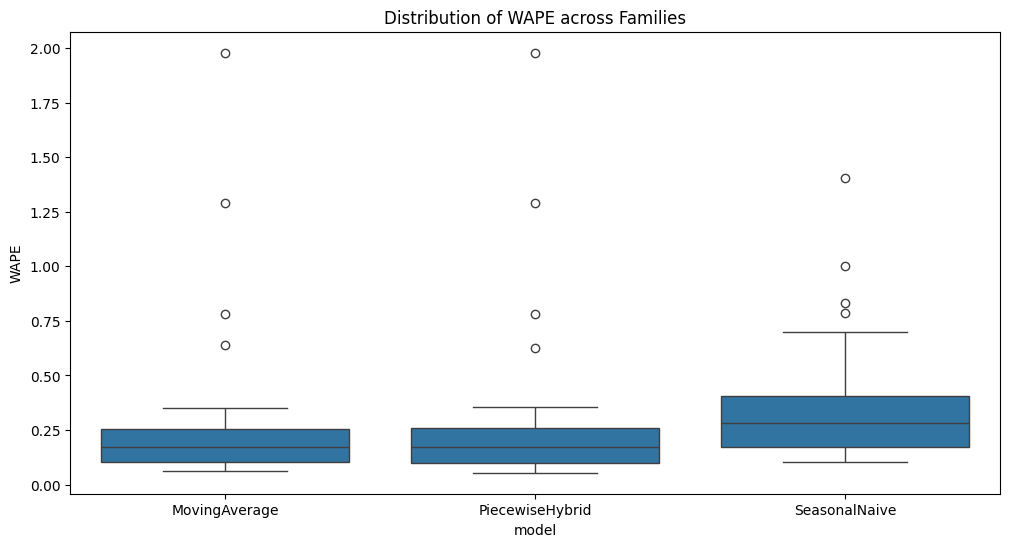

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=family_scores, x='model', y='WAPE')
plt.title("Distribution of WAPE across Families")
plt.show()

## 5. Residual Diagnostics

Check if the errors of the best model (Hybrid) are random or structured.

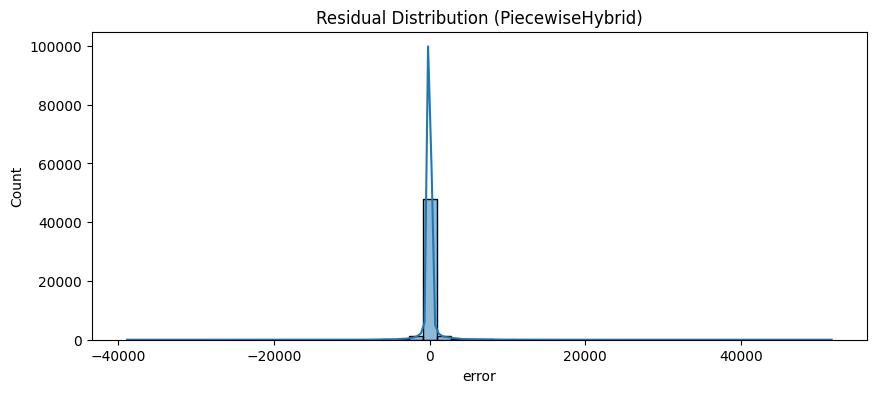

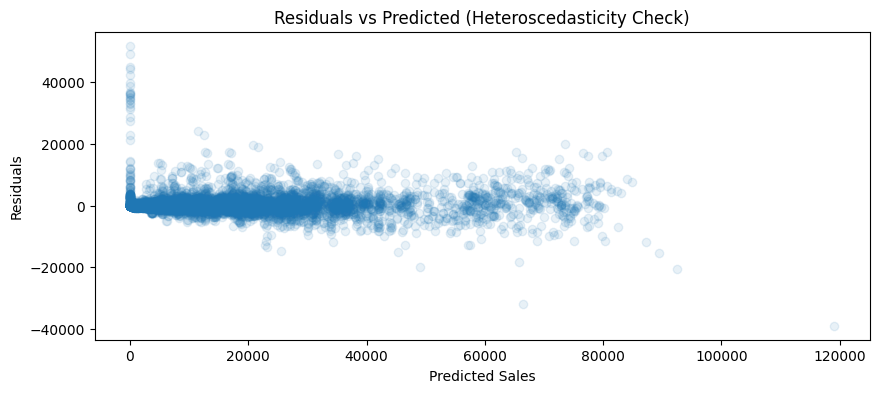

In [8]:
best_model_df = full_eval[full_eval['model'] == 'PiecewiseHybrid'].copy()
best_model_df['error'] = best_model_df['sales'] - best_model_df['yhat']

# 1. Error Distribution
plt.figure(figsize=(10, 4))
sns.histplot(best_model_df['error'], bins=50, kde=True)
plt.title("Residual Distribution (PiecewiseHybrid)")
plt.show()

# 2. Residuals vs Predicted
plt.figure(figsize=(10, 4))
plt.scatter(best_model_df['yhat'], best_model_df['error'], alpha=0.1)
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Heteroscedasticity Check)")
plt.show()

## 6. Business Impact: Stock-out Simulation

Rough estimation: If we held safety stock = `1.65 * RMSE` (95% service level assumption for normal errors), what would be our inventory cost vs stockout risk?

For this audit, we'll keep it simple: **Opportunity Cost**.
*   Under-forecast (Sales > Forecast) -> Potential Lost Sales.
*   Over-forecast (Forecast > Sales) -> Excess Inventory Cost.

In [9]:
def calc_business_loss(row):
    if pd.isna(row['yhat']) or pd.isna(row['sales']): return 0.0
    error = row['sales'] - row['yhat']
    if error > 0:
        # Under-forecast: Lost sales
        return error * 1.0 
    else:
        # Over-forecast: Holding cost (20%)
        return abs(error) * 0.2

full_eval['loss_score'] = full_eval.apply(calc_business_loss, axis=1)

business_score = full_eval.groupby('model')['loss_score'].sum().sort_values()
print("Total 'Business Loss' Score (Lower is Better):")
print(business_score)

Total 'Business Loss' Score (Lower is Better):
model
MovingAverage      1.010006e+07
PiecewiseHybrid    1.118047e+07
SeasonalNaive      2.519558e+07
Name: loss_score, dtype: float64
